# Visualize Speech

### recording myself

In [57]:
import pyaudio
import wave
import time
import sys

# Recording parameters
FORMAT = pyaudio.paInt16  # Audio format (16-bit PCM)
CHANNELS = 1              # Mono audio
RATE = 44100             # Sample rate (Hz)
CHUNK = 1024             # Frames per buffer
RECORD_SECONDS = 5       # Duration of recording
OUTPUT_FILE = "/Users/amitt/Downloads/recording.wav"  # Output WAV file name

def record_audio():
    # Initialize PyAudio
    audio = pyaudio.PyAudio()

    try:
        # Open stream for recording
        stream = audio.open(format=FORMAT,
                            channels=CHANNELS,
                            rate=RATE,
                            input=True,
                            frames_per_buffer=CHUNK)

        print("Recording... (Press Ctrl+C to stop early)")

        # List to store audio frames
        frames = []

        # Record for the specified duration
        start_time = time.time()
        try:
            while time.time() - start_time < RECORD_SECONDS:
                data = stream.read(CHUNK, exception_on_overflow=False)
                frames.append(data)
        except KeyboardInterrupt:
            print("\nRecording stopped early by user.")
        except Exception as e:
            print(f"Error during recording: {e}")
            sys.exit(1)

        print("Recording finished.")

        # Stop and close the stream
        stream.stop_stream()
        stream.close()
        audio.terminate()

        # Save the recorded data to a WAV file
        try:
            with wave.open(OUTPUT_FILE, 'wb') as wf:
                wf.setnchannels(CHANNELS)
                wf.setsampwidth(audio.get_sample_size(FORMAT))
                wf.setframerate(RATE)
                wf.writeframes(b''.join(frames))
            print(f"Audio saved to {OUTPUT_FILE}")
        except Exception as e:
            print(f"Error saving WAV file: {e}")
            sys.exit(1)

    except Exception as e:
        print(f"Error initializing audio stream: {e}")
        audio.terminate()
        sys.exit(1)

if __name__ == "__main__":
    record_audio()

Recording... (Press Ctrl+C to stop early)
Recording finished.
Audio saved to /Users/amitt/Downloads/recording.wav


### visualizing the audio

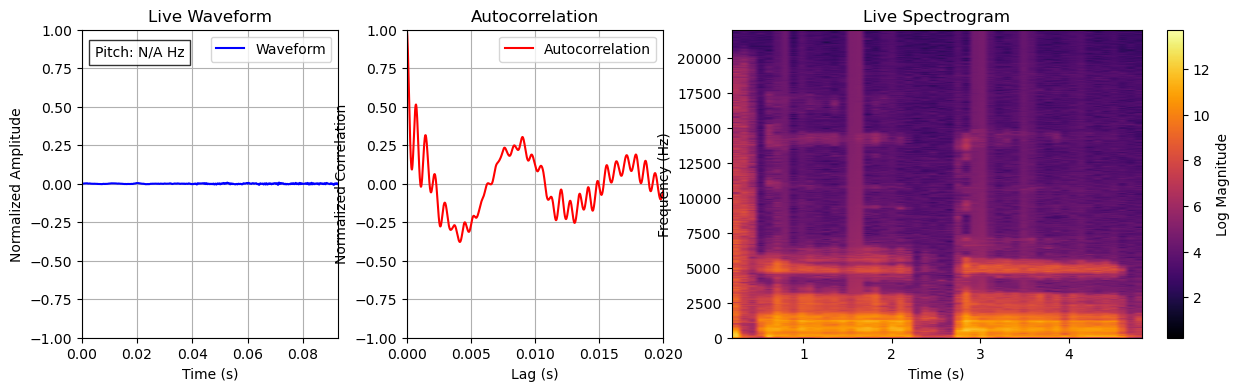

In [ ]:
%matplotlib notebook
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from IPython.display import display, clear_output
import warnings

# Suppress warnings for cleaner output (optional)
warnings.filterwarnings("ignore")

# Audio file path (replace with your WAV file)
AUDIO_FILE = "/Users/amitt/Downloads/recording.wav"  # Or "sample.wav"

# Parameters for audio processing
CHUNK = 4096  # Number of frames per buffer
WINDOW = np.hamming(CHUNK)  # Window function for spectrogram
SAMPLE_RATE = 44100  # Default sample rate
PITCH_MIN = 50  # Minimum pitch in Hz
PITCH_MAX = 500  # Maximum pitch in Hz

def get_max_amplitude(wav_file):
    """Read the entire WAV file to find the maximum amplitude."""
    wf = wave.open(wav_file, 'rb')
    channels = wf.getnchannels()
    n_frames = wf.getnframes()
    data = wf.readframes(n_frames)
    audio_data = np.frombuffer(data, dtype=np.int16)
    if channels > 1:
        audio_data = audio_data[::channels]  # Take left channel
    max_amplitude = np.max(np.abs(audio_data)) if len(audio_data) > 0 else 1.0
    wf.close()
    return max_amplitude

def estimate_pitch(audio_data, sample_rate, min_freq=PITCH_MIN, max_freq=PITCH_MAX):
    """Estimate pitch using autocorrelation and return autocorrelation data."""
    # Apply window to reduce edge effects
    windowed_data = audio_data * np.hamming(len(audio_data))
    
    # Compute autocorrelation
    autocorr = np.correlate(windowed_data, windowed_data, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # Positive lags
    
    # Normalize autocorrelation
    autocorr = autocorr / np.max(np.abs(autocorr)) if np.max(np.abs(autocorr)) > 0 else autocorr
    
    # Pad or truncate to ensure length = CHUNK for plotting
    if len(autocorr) < CHUNK:
        autocorr = np.pad(autocorr, (0, CHUNK - len(autocorr)), mode='constant')
    elif len(autocorr) > CHUNK:
        autocorr = autocorr[:CHUNK]
    
    # Find first zero crossing for pitch estimation (optional, for stability)
    autocorr_for_pitch = autocorr.copy()
    zero_crossings = np.where(autocorr_for_pitch <= 0)[0]
    if len(zero_crossings) > 0:
        autocorr_for_pitch = autocorr_for_pitch[:zero_crossings[0]]
    
    # Find peak in autocorrelation within pitch range
    min_lag = int(sample_rate / max_freq)
    max_lag = int(sample_rate / min_freq)
    if max_lag >= len(autocorr_for_pitch):
        return None, autocorr
    
    # Find the lag with maximum autocorrelation
    peak_lag = min_lag + np.argmax(autocorr_for_pitch[min_lag:max_lag])
    
    # Compute pitch (Hz)
    if autocorr_for_pitch[peak_lag] > 0.1:  # Threshold for voiced detection
        pitch = sample_rate / peak_lag
        if min_freq <= pitch <= max_freq:
            return pitch, autocorr
    return None, autocorr

def play_audio_and_visualize():
    # Get maximum amplitude from the entire WAV file
    max_amplitude = get_max_amplitude(AUDIO_FILE)
    print(f"Global max amplitude: {max_amplitude}")

    # Open the WAV file for playback
    try:
        wf = wave.open(AUDIO_FILE, 'rb')
    except FileNotFoundError:
        print(f"Error: The file '{AUDIO_FILE}' was not found. Please provide a valid WAV file path.")
        return
    except Exception as e:
        print(f"Error opening WAV file: {e}")
        return

    sample_rate = wf.getframerate()
    channels = wf.getnchannels()
    chunk_duration = CHUNK / sample_rate  # Duration of one chunk in seconds

    print(f"Sample rate: {sample_rate} Hz, Channels: {channels}, Chunk duration: {chunk_duration:.4f} s")

    # Initialize PyAudio
    p = pyaudio.PyAudio()

    try:
        # Open stream for playback
        stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                        channels=channels,
                        rate=sample_rate,
                        output=True)

        # Set up matplotlib for live plotting
        plt.close('all')  # Close any existing figures
        fig, (ax_wave, ax_autocorr, ax_spec) = plt.subplots(1, 3, figsize=(15, 4), 
                                                            gridspec_kw={'width_ratios': [1, 1, 2]})

        # Waveform setup
        times = np.linspace(0, chunk_duration, CHUNK)  # Fixed time axis for one chunk
        wave_line, = ax_wave.plot(times, np.zeros(CHUNK), 'b-', label='Waveform')
        ax_wave.set_xlabel('Time (s)')
        ax_wave.set_ylabel('Normalized Amplitude')
        ax_wave.set_title('Live Waveform')
        ax_wave.set_xlim(0, chunk_duration)
        ax_wave.set_ylim(-1.0, 1.0)
        ax_wave.grid(True)
        ax_wave.legend()
        pitch_text = ax_wave.text(0.05, 0.95, 'Pitch: N/A Hz', transform=ax_wave.transAxes, 
                                 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        # Autocorrelation setup
        autocorr_times = np.linspace(0, chunk_duration, CHUNK)  # Lags in seconds
        autocorr_line, = ax_autocorr.plot(autocorr_times, np.zeros(CHUNK), 'r-', label='Autocorrelation')
        ax_autocorr.set_xlabel('Lag (s)')
        ax_autocorr.set_ylabel('Normalized Correlation')
        ax_autocorr.set_title('Autocorrelation')
        ax_autocorr.set_xlim(0, min(0.02, chunk_duration))  # Show up to 20 ms
        ax_autocorr.set_ylim(-1.0, 1.0)
        ax_autocorr.grid(True)
        ax_autocorr.legend()

        # Spectrogram setup
        freqs = np.fft.fftfreq(CHUNK, 1.0 / sample_rate)[:CHUNK//2]
        spectrogram_data = []
        spec_img = ax_spec.imshow([[0]], aspect='auto', origin='lower', 
                                 extent=[0, chunk_duration, 0, sample_rate/2], cmap='inferno')
        ax_spec.set_xlabel('Time (s)')
        ax_spec.set_ylabel('Frequency (Hz)')
        ax_spec.set_title('Live Spectrogram')
        plt.colorbar(spec_img, ax=ax_spec, label='Log Magnitude')

        # Display the figure
        fig.canvas.draw()
        display(fig)

        # Initialize time tracking
        current_time = 0.0  # Current playback position in seconds
        chunk_count = 0  # Number of chunks processed

        # Read and process audio in chunks
        data = wf.readframes(CHUNK)
        while data:
            # Play audio
            stream.write(data)

            # Convert data to numpy array
            audio_data = np.frombuffer(data, dtype=np.int16)
            if len(audio_data) == CHUNK * channels:
                # If stereo, take one channel
                if channels > 1:
                    audio_data = audio_data[::channels]
                
                # Normalize audio data
                audio_data_normalized = audio_data / max_amplitude if max_amplitude > 0 else audio_data
                
                # Estimate pitch and get autocorrelation
                pitch, autocorr = estimate_pitch(audio_data, sample_rate)
                pitch_str = f"Pitch: {pitch:.1f} Hz" if pitch else "Pitch: N/A Hz"
                print(f"Chunk {chunk_count}: Audio data shape: {audio_data_normalized.shape}, "
                      f"Max normalized amplitude: {np.max(np.abs(audio_data_normalized)):.4f}, "
                      f"{pitch_str}, Autocorr shape: {autocorr.shape}")

                # Update waveform
                wave_line.set_ydata(audio_data_normalized)
                ax_wave.set_xlim(0, chunk_duration)
                pitch_text.set_text(pitch_str)

                # Update autocorrelation
                autocorr_line.set_ydata(autocorr)
                ax_autocorr.set_xlim(0, min(0.02, chunk_duration))

                # Compute FFT for spectrogram
                windowed_data = audio_data * WINDOW
                fft_data = fft(windowed_data)
                fft_magnitude = np.abs(fft_data)[:CHUNK//2]

                # Update spectrogram data
                spectrogram_data.append(fft_magnitude)
                if len(spectrogram_data) > 50:
                    spectrogram_data.pop(0)

                # Update spectrogram plot
                spec_img.set_array(np.log1p(np.array(spectrogram_data).T))
                spec_img.set_extent([current_time - len(spectrogram_data) * chunk_duration, 
                                     current_time, 0, sample_rate/2])
                spec_img.autoscale()

                # Refresh plot
                fig.canvas.draw()
                clear_output(wait=True)
                display(fig)
                plt.pause(0.001)

                # Update time
                current_time += chunk_duration
                chunk_count += 1

            # Read next chunk
            data = wf.readframes(CHUNK)

        # Cleanup
        stream.stop_stream()
        stream.close()
        p.terminate()
        wf.close()
        plt.close(fig)

    except Exception as e:
        print(f"An error occurred: {e}")
        stream.stop_stream()
        stream.close()
        p.terminate()
        wf.close()

if __name__ == "__main__":
    play_audio_and_visualize()